# LoFi

In this demo, we take Diagonal LoFi for the 1d-regression problem in continual learning and compare the peformance of the method when using Fourier features v.s. not using Fourier features

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax
import jax.numpy as jnp
import flax.linen as nn
from typing import Callable
import matplotlib.pyplot as plt
from functools import partial
from jax.flatten_util import ravel_pytree

In [3]:
from rebayes import base
from rebayes.utils.preprocessing import fourier_basis
from rebayes.low_rank_filter import lofi
from rebayes.utils import nonstat_1d_data as datagen
from rebayes.utils.utils import get_subtree, tree_to_cpu

In [4]:
%config InlineBackend.figure_format = "retina"

## Dataset

In [5]:
key = jax.random.PRNGKey(314)
key_data, key_basis = jax.random.split(key)
n_dist = 6
n_train = 100
data_flat, data_tasks = datagen.sample_1d_regression_sequence(key, n_dist, n_train=n_train)


num_basis, input_dim = 5, 1
b = jax.random.normal(key_basis, (num_basis, input_dim)) * 0.5
jax.tree_map(jnp.shape, data_flat)

{'test': {'X': (600, 1), 'id_seq': (600,), 'y': (600, 1)},
 'train': {'X': (600, 1), 'id_seq': (600,), 'y': (600, 1)}}

In [6]:
X_train_seq = data_flat["train"]["X"]
X_train_seq_fourier = fourier_basis(X_train_seq, b)
Y_train_seq = data_flat["train"]["y"]
train_id_seq = data_flat["train"]["id_seq"]

X_test_seq = data_flat["test"]["X"]
X_test_seq_fourier = fourier_basis(X_test_seq, b)
Y_test_seq = data_flat["test"]["y"]
test_id_set = data_flat["test"]["id_seq"]


X_test_tasks_flat = data_tasks["test"]["X"]
X_test_tasks_fourier = fourier_basis(X_test_tasks_flat, b)
Y_test_tasks = data_tasks["test"]["y"]

X_train_tasks_flat = data_tasks["train"]["X"]
X_train_tasks_fourier = fourier_basis(X_train_tasks_flat, b)
Y_train_tasks = data_tasks["train"]["y"]

## Setup 

In [7]:
class MLP(nn.Module):
    n_out: int
    n_hidden: int
    activation: Callable = nn.elu
    
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(self.n_hidden)(x)
        x = self.activation(x)
        # x = nn.Dense(self.n_hidden)(x)
        # x = self.activation(x)
        x = nn.Dense(self.n_out)(x)
        return x
    
def make_bnn_flax(dim_in, nhidden=50):
    key = jax.random.PRNGKey(314)
    dim_out = 1
    model = MLP(dim_out, nhidden)
    params = model.init(key, jnp.ones((1, dim_in)))
    flat_params, recfn = ravel_pytree(params)
    n_params = len(flat_params)
    return model, params, flat_params, recfn

In [8]:
def callback(bel, pred_obs, t, Xt, Yt, bel_pred, apply_fn, X_test, Y_test, **kwargs):
    # eval on current task 
    task = train_id_seq[t]
    yhat = apply_fn(bel.mean, X_test[task]).squeeze()
    ytrue = Y_test[task].squeeze()
    
    rmse_test_current_task = jnp.sqrt(jnp.mean(jnp.square(yhat - ytrue)))
    mae_test_current_task = jnp.mean(jnp.abs(yhat - ytrue))

    out = {
           'rmse_test_current_task': rmse_test_current_task,
           'mae_test_current_task': mae_test_current_task,
           'pred_test_current_task': yhat,
           "bel": bel,
           }
    
    return out

# Fit

In [9]:
base_ssm_params = base.RebayesParams(
        initial_mean=None,
        initial_covariance=0.06,
        dynamics_weights=1,
        dynamics_covariance=1e-7,#1e-6,
        emission_mean_function=None,
        emission_cov_function = lambda w,x: 0.02,
        adaptive_emission_cov=False,
        dynamics_covariance_inflation_factor=0.001,
)

mem = 10
lofi_params = lofi.LoFiParams(memory_size=mem, steady_state=False)

In [10]:
collection_agents = {}
collection_outputs = {}

## Flat

In [11]:
_, dim_in = X_train_seq.shape
model, dnn_params, flat_params, recfn = make_bnn_flax(dim_in)

def apply_fn_flat(flat_params, x, model, recfn):
    return model.apply(recfn(flat_params), x)

ssm_params = base_ssm_params.replace(
    initial_mean=flat_params,
    emission_mean_function=partial(apply_fn_flat, model=model, recfn=recfn)
)

agent = lofi.RebayesLoFiDiagonal(ssm_params, lofi_params)

callback_part = partial(callback,
                        X_test=X_test_tasks_flat,
                        Y_test=Y_test_tasks,
                        apply_fn=agent.params.emission_mean_function,
                       )

bel, outputs = agent.scan(X_train_seq, Y_train_seq, callback=callback_part, progress_bar=False)
bel = jax.block_until_ready(bel)

method = "flat"
collection_agents[method] = agent
collection_outputs[method] = outputs

## Fourier

In [12]:
_, dim_in = X_train_seq_fourier.shape
model, dnn_params, flat_params, recfn = make_bnn_flax(dim_in)

def apply_fn_flat(flat_params, x, model, recfn):
    return model.apply(recfn(flat_params), x)

ssm_params = base_ssm_params.replace(
    initial_mean=flat_params,
    emission_mean_function=partial(apply_fn_flat, model=model, recfn=recfn)
)

agent = lofi.RebayesLoFiDiagonal(ssm_params, lofi_params)

callback_part = partial(callback,
                        X_test=X_test_tasks_fourier,
                        Y_test=Y_test_tasks,
                        apply_fn=agent.params.emission_mean_function,
                       )

bel, outputs = agent.scan(X_train_seq_fourier, Y_train_seq, callback=callback_part, progress_bar=False)
bel = jax.block_until_ready(bel)


method = "fourier"
collection_agents[method] = agent
collection_outputs[method] = outputs

# Eval

In [13]:
keyv = "rmse_test_current_task"
metrics = tree_to_cpu(get_subtree(collection_outputs, keyv))

In [16]:
import numpy as np

Text(0.5, 1.0, 'RMSE on current task')

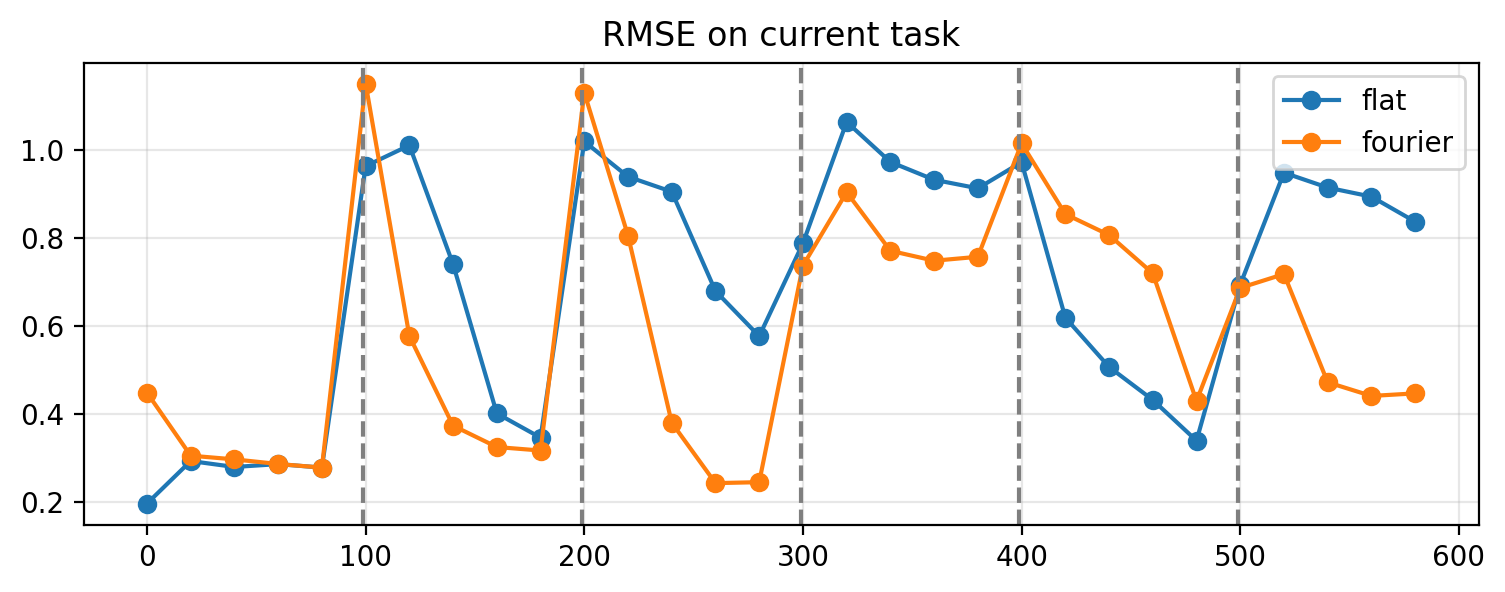

In [17]:
ksize = 10
kernel = jnp.ones(ksize) / ksize
changepoints = np.arange(n_train, n_dist * n_train, step=n_train) - 1

fig, ax = plt.subplots(figsize=(9, 3))
for method in metrics:
    hist_err = jnp.convolve(metrics[method], kernel, mode="same")
    ndata = len(hist_err)
    ndx = jnp.arange(0, ndata, step=20)
    ax.plot(ndx, hist_err[ndx], marker="o", label=method)

for c in changepoints:
    ax.axvline(x=c, color="tab:gray", linestyle="--")

plt.legend()
plt.grid(alpha=0.3)
plt.title("RMSE on current task")

## Comparisson posterior mean

In [18]:
def reshape_task(x):
    _, *shape = x.shape
    new_shape = (n_dist, -1, *shape)
    return x.reshape(new_shape)

@partial(jax.vmap, in_axes=(None, 0, None, None, None))
@partial(jax.vmap, in_axes=(0, 0, None, None, None))
def xsample(key, bel, agent, x, n_samples):
    # x = fourier_basis(x, b)
    yhat_samples = agent.pred_obs_mc(key, bel, x, shape=(n_samples,))
    return yhat_samples

In [19]:
key = jax.random.PRNGKey(3141)

In [21]:
%%time
n_samples = 55

ntest = 100
xtest_ravel = jnp.linspace(-2.0, 2.0, num=ntest)[:, None]
xtest_ravel_fourier = fourier_basis(xtest_ravel, b)
keys = jax.random.split(key, ntest)

# Perform inference in cpu
# collection_outputs = tree_to_cpu(collection_outputs)
# keys = tree_to_cpu(keys)
# xtest_ravel_fourier = np.array(xtest_ravel_fourier)

method = "flat"
outputs = collection_outputs[method]
agent = collection_agents[method]
bel_reshape = jax.tree_map(reshape_task, outputs["bel"])

yhat_xmap = xsample(keys, bel_reshape, agent, xtest_ravel, n_samples).squeeze()

CPU times: user 56.4 s, sys: 4.3 s, total: 1min
Wall time: 7.22 s


In [23]:
method = "fourier"
outputs = collection_outputs[method]
agent = collection_agents[method]
bel_reshape = jax.tree_map(reshape_task, outputs["bel"])
yhat_xmap_fourier = xsample(keys, bel_reshape, agent, xtest_ravel_fourier, n_samples).squeeze()

CPU times: user 10.2 s, sys: 1.92 s, total: 12.1 s
Wall time: 7.04 s


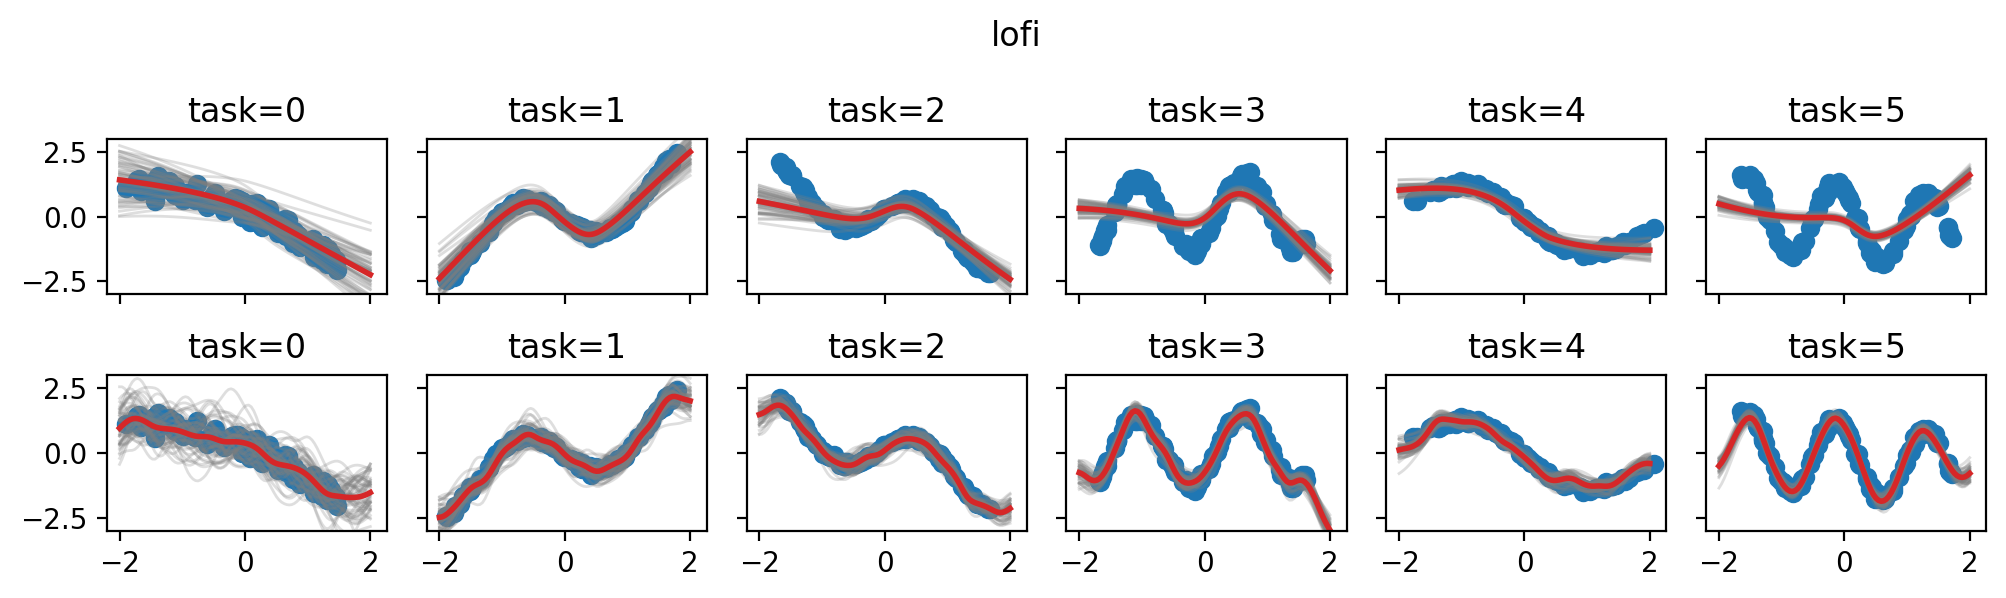

In [24]:
%%time
num_obs = 99
method = "lofi"
    
fig, axs_collection = plt.subplots(2, 6, figsize=(10, 3), sharex=True, sharey=True)
y_collection = [yhat_xmap, yhat_xmap_fourier]
y_collection = jax.tree_map(np.array, y_collection)

for y_all, axs in zip(y_collection, axs_collection):
    yhat_samples_all = y_all[:, num_obs, ...]
    
    for task, ax in enumerate(axs.ravel()):
        yhat_samples = yhat_samples_all[task]
        yhat_mean = yhat_samples.mean(axis=0)

        for yhat in yhat_samples:
            ax.plot(xtest_ravel, yhat, c="tab:gray", linewidth=1, alpha=0.25)
        ax.plot(xtest_ravel, yhat_mean, c="tab:red", linewidth=2)
        ax.scatter(X_train_tasks_flat[task, :num_obs], Y_train_tasks[task, :num_obs])
        ax.set_title(f"{task=}")
        ax.set_ylim(-3, 3)
    plt.suptitle(method)
    plt.tight_layout()

In [ ]:
n_tot = 2 * n_train - 1
n_frames = 20
ix_frames = np.linspace(0, n_tot, n_frames).round().astype(int)

## An animation

In [30]:
import numpy as np
from matplotlib.animation import FuncAnimation

In [31]:
X_test_tasks_flat = np.array(X_test_tasks_flat)
Y_test_tasks = np.array(Y_test_tasks)
yhat_xmap = np.array(yhat_xmap)
xtest_ravel = np.array(xtest_ravel)

CPU times: user 2min 15s, sys: 4.32 s, total: 2min 19s
Wall time: 2min 4s


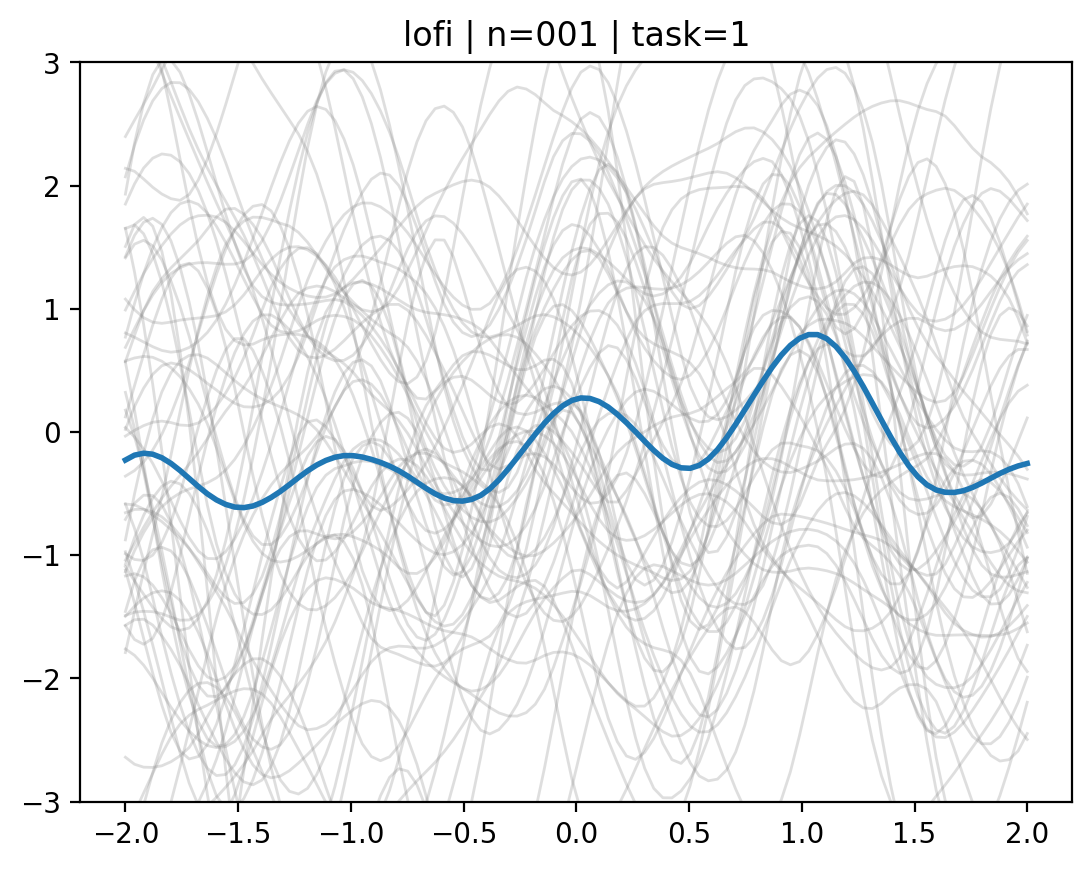

In [39]:
%%time
fig, ax = plt.subplots()

label = "lofi"

nmin = 0
def update(ix):
    
    num_obs = ix % n_train
    task = ix // n_train
    
    xtest = X_test_tasks_flat[task][:num_obs]
    
    ax.cla()
    yhat_samples = yhat_xmap[task, num_obs, ...]
    yhat_mean = yhat_samples.mean(axis=0)

    for yhat in yhat_samples:
        ax.plot(xtest_ravel, yhat, c="tab:gray", linewidth=1, alpha=0.25)
    ax.plot(xtest_ravel, yhat_mean, c="tab:blue", linewidth=2)

    xtest = X_train_tasks_flat[task][nmin:num_obs]
    ytrue = Y_train_tasks[task].ravel()[nmin:num_obs]
    ax.scatter(xtest, ytrue, facecolors="none", edgecolors="tab:gray")
    
    if len(xtest) > 0:
        ax.scatter(xtest[-1], ytrue[-1], c="tab:red")

    ax.set_ylim(-3, 3)
    ax.set_title(f"{label} | n={num_obs+1:03} | task={task+1}")
    
frames = np.arange(n_dist * n_train)
ani = FuncAnimation(fig, update, frames=frames)
ani.save("./figures/lofi-posterior-predictive-fourier.mp4", dpi=100, bitrate=-1, fps=10)